# Clustering
Often, we think of data in terms of groups, e.g., "People with a smoking habit and over 60 are more likely to die of Covid."
Sometimes these groups are given, and we can assign each record to a group.
But more often, the question itself is: which are the groups?

## K-Means

K-means is a clustering algorithm which clusters data according to its proximity.
It follows a simple algorithm:
- select a set of centroids
- assign every record to its closest centroid
- update the centroids

In [40]:
from datasets import load_dataset
from sklearn.cluster import KMeans


dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
dataset = dataset.loc[range(100)]  # range(n) creates an iterable of numbers from 0 to n
numeric_dataset = dataset.select_dtypes(include="number")

clustering_algorithm = KMeans(n_clusters=10)
clustering_algorithm.fit(numeric_dataset.values)
kmeans_clustering = clustering_algorithm.labels_

In [41]:
kmeans_clustering
dataset.loc[, "cluster"] = kmeans_clustering

array([8, 7, 4, 4, 8, 4, 7, 3, 6, 3, 7, 0, 4, 9, 4, 3, 3, 9, 2, 8, 0, 4,
       4, 6, 7, 9, 1, 1, 3, 2, 4, 4, 3, 4, 7, 9, 8, 3, 8, 9, 1, 8, 8, 9,
       7, 4, 5, 0, 4, 9, 7, 3, 3, 8, 4, 3, 3, 7, 9, 8, 2, 6, 9, 0, 5, 3,
       1, 1, 4, 7, 1, 7, 7, 3, 9, 7, 8, 4, 9, 9, 2, 0, 9, 1, 9, 4, 9, 9,
       1, 4, 4, 3, 3, 3, 7, 9, 7, 4, 9, 0], dtype=int32)

## Hierarchical clustering

Clusterings induced by K-Means are "flat", that is, we have no inter-cluster relationships, which only gives us partial information.
Hierarchical clustering instead allows us to create a true hierarchy of clusters, each in a sub-cluster relationship with another.

In [34]:
from datasets import load_dataset
from sklearn.cluster import AgglomerativeClustering


dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
dataset = dataset.loc[range(100)]  # range(n) creates an iterable of numbers from 0 to n
numeric_dataset = dataset.select_dtypes(include="number")

clustering_algorithm = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clustering_algorithm.fit(numeric_dataset.values)
hierarchical_clustering = clustering_algorithm.labels_

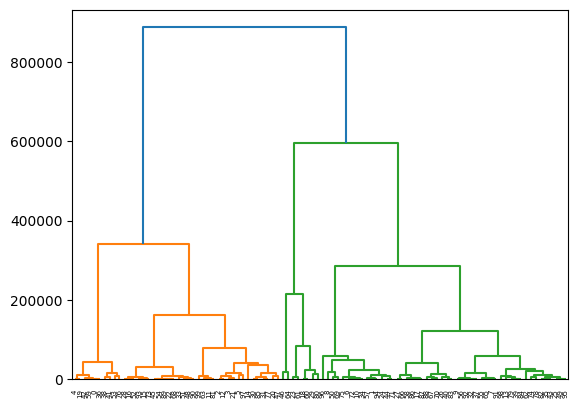

In [35]:
from scipy.cluster.hierarchy import dendrogram
import numpy


def plot_dendrogram(model, **kwargs):
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(clustering_algorithm)

Clusters are still datasets, hence we can repeat the data understanding loop!

In [42]:
import pandas

pandas.set_option("display.max_columns", None)

dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
dataset = dataset.loc[range(100)]

dataset.loc[:, "cluster_label"] = kmeans_clustering
dataset.groupby("cluster_label").describe()["capital_gain"]

,count,mean,std,min,25%,50%,75%,max
cluster_label,,,,,,,,
0,6.0,731.000000,1790.577002,0.0,0.0,0.0,0.00,4386.0
1,8.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
2,4.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
3,16.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
4,19.0,2232.210526,6695.402930,0.0,0.0,0.0,0.00,27828.0
5,2.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
6,3.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
7,14.0,3830.071429,11022.825315,0.0,0.0,0.0,0.00,41310.0
8,10.0,636.000000,2011.208592,0.0,0.0,0.0,0.00,6360.0


# Outliers
Outliers are records which stand out from the crowd and thus may be treated differently.
These records may even be out of distribution, thus they *should* be treated differently, and possibly removed from your analysis.

In [ ]:
from sklearn.ensemble import IsolationForest


dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
numeric_dataset = dataset.select_dtypes(include="number")
numeric_dataset = numeric_dataset.drop("over_threshold", axis="columns")

detector = IsolationForest()
detector.fit(numeric_dataset.values)
outliers = detector.predict(numeric_dataset.values)
outliers = numpy.array(list(map(lambda inlier_score: inlier_score == -1, outliers)))

dataset.loc[:, "is_outlier"] = outliers

In [44]:
outliers

array([False, False, False, ..., False, False, False])

# Novelties
Novelties are, unlike outliers, outside the distribution, but do not necessarily present outlier features.

In [ ]:
from sklearn.svm import OneClassSVM


dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
numeric_dataset = dataset.select_dtypes(include="number")
numeric_dataset = numeric_dataset.drop("over_threshold", axis="columns")

detector = OneClassSVM()
detector.fit(numeric_dataset.values)
novelties = detector.predict(numeric_dataset)
novelties = numpy.array(list(map(lambda inlier_score: inlier_score == -1, novelties)))

dataset.loc[:, "is_novelty"] = novelties

In [ ]:
outliers